In [39]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import nibabel as nib
import numpy.ma as ma
from numpy import savetxt
import os
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
import brainstat.mesh.data as mesh

#input variables and path defs
workDir = '/data_/mica1/03_projects/hans/7T/func/'
outDir = str(workDir+'outputs/')
volDir = '/data_/mica3/BIDS_PNC/rawdata/'
regDir = '/data_/mica1/03_projects/hans/7T/registration/'
outDir1 = '/host/percy/local_raid/hans/amyg/func/'


In [40]:
#makes hemisphere plots of z-scored average pearson correlation of all subject timeseries FOR WHOLE AMYGDALA
thrshhld=25
gauss=10

from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
import brainstat.mesh.data as mesh
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data
corr_all_subs=np.zeros((1,10,64984))
for count, i in enumerate([1,4,5,6,7,9,10,11,12,13]):
    if i<10:
        subject = str('PNC00'+str(i))
    else:
        subject = str('PNC0'+str(i))
    path=str(outDir1+subject+'_fisherZ_whole_amyg_with_cortex_gs'+str(gauss)+'.txt')
    PcorrAmyg=np.loadtxt(path)
    corr_all_subs[0][count][:]=PcorrAmyg

PcorrAmyg=np.average(corr_all_subs[0][:][:],axis=0)

#make array for all U1 and U2 correlations 
corr_all_subs=np.zeros((2,10,64984))
for count, i in enumerate([1,4,5,6,7,9,10,12,13]):
    if i<10:
        subject = str('PNC00'+str(i))
    else:
        subject = str('PNC0'+str(i))
    path=str(outDir1+subject+'_U1U2_fisherZ_top_bot_'+str(thrshhld)+'_with_cortex_gs'+str(gauss)+'.txt')
    Pcorr=np.loadtxt(path)
    Pcorr=Pcorr[:2][:]

    corr_all_subs[0][count][:]=Pcorr[0][:]
    corr_all_subs[1][count][:]=Pcorr[1][:]
    #cor=map_to_labels(Pcorr)

Pcorr[0,:]=np.average(corr_all_subs[0][:][:],axis=0)
Pcorr[1,:]=np.average(corr_all_subs[1][:][:],axis=0)

In [12]:
###make mixed effects model for the timeseries treat subjects as random variable and look at differences between segments (Only analysis on U1)
mmMatrix=np.zeros((40,64984))
counter=0
for i in [1,4,5,6,7,9,10,11,12,13]:
    if i<10:
        subject = str('PNC00'+str(i))
    else:
        subject = str('PNC0'+str(i))
    path=str(outDir1+subject+'_U1U2_fisherZ_top_bot_'+str(thrshhld)+'_with_cortex_gs'+str(gauss)+'.txt')
    #path=str(outDir1+subject+'_U1U2_fisherZ_top_bot_'+str(thrshhld)+'_with_cortex_test.txt')
    fisherZ=np.loadtxt(path)
    mmMatrix[counter,:]=fisherZ[0,:]
    mmMatrix[counter+9,:]=fisherZ[2,:]
    mmMatrix[counter+18,:]=fisherZ[1,:]
    mmMatrix[counter+27,:]=fisherZ[3,:]
    counter=counter+1
#isolate only U1 data since further analysis will only be with U1
mmMatrixU1=np.delete(mmMatrix,[10,11,12,13,14,15,16,17,18,19],axis=0)
mmMatrixU1=np.delete(mmMatrixU1,[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1],axis=0)

In [13]:
#make mixed effects model of different network connectivities between subregions while accounting for different subjects
from brainstat.stats.terms import MixedEffect, FixedEffect
from brainstat.stats.SLM import SLM
import pandas as pd
from brainstat.datasets import fetch_mask, fetch_template_surface
mask=fetch_mask('fslr32k')
surf_combined = fetch_template_surface('fslr32k', join=True)

subU1=np.array(['sub1','sub1','sub2','sub2','sub3','sub3','sub4','sub4','sub5','sub5','sub6','sub6','sub7','sub7','sub8','sub8','sub9','sub9','sub10','sub10'])
segU1=np.array(['upper','lower','upper','lower','upper','lower','upper','lower','upper','lower','upper','lower','upper','lower','upper','lower','upper','lower','upper','lower'])

attributes={'sub':subU1,'seg':segU1}


df=pd.DataFrame(data=mmMatrixU1)
term_sub = MixedEffect(attributes['sub'])

term_seg = FixedEffect(attributes['seg'])
contrast_seg=(segU1 == "upper").astype(int) - (segU1 == "lower").astype(int)
model_mixed = term_sub + term_seg

slm_mixed = SLM(
    model_mixed,
    contrast_seg,
    surf='fslr32k',
    mask=mask,
    correction=["rft"],
    cluster_threshold=0.01,
    two_tailed=False,
)

slm_mixed.fit(mmMatrixU1)

In [14]:
###CONTEXT DECODING of difference between top and bot 25%
##meta-analysis
from brainstat.context.meta_analysis import meta_analytic_decoder
meta_analysis_diff = meta_analytic_decoder("fslr32k", slm_mixed.t.flatten(), data_dir='/export02/data/hans/meta-data/')
print(meta_analysis_diff)

2024-02-20 16:48:58,004 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-02-20 16:48:58,115 - brainstat - INFO - Running correlations with all Neurosynth features.
                     Pearson's r
ventral medial          0.260063
self referential        0.235342
cortex mpfc             0.229944
referential             0.226451
mpfc                    0.225679
...                          ...
orienting              -0.396464
spatial information    -0.403626
eye movements          -0.408979
eye                    -0.410976
task relevant          -0.416719

[3228 rows x 1 columns]


In [15]:
###CONTEXT DECODING of U1 top 25% values
##meta-analysis
from brainstat.context.meta_analysis import meta_analytic_decoder
meta_analysis_top25 = meta_analytic_decoder("fslr32k", Pcorr[0][:].flatten(), data_dir='/export02/data/hans/meta-data/')
print(meta_analysis_top25)

2024-02-20 16:51:12,676 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-02-20 16:51:12,776 - brainstat - INFO - Running correlations with all Neurosynth features.
                        Pearson's r
amygdala hippocampus       0.278934
anterior temporal          0.238715
temporal pole              0.238261
parahippocampus            0.186910
hypothalamus               0.164892
...                             ...
frontoparietal network    -0.544427
fronto parietal           -0.546973
lateral frontal           -0.548989
parietal network          -0.549615
frontoparietal            -0.551534

[3228 rows x 1 columns]


In [16]:
###CONTEXT DECODING of U1 bottom 25% values
##meta-analysis
from brainstat.context.meta_analysis import meta_analytic_decoder
meta_analysis_bot25 = meta_analytic_decoder("fslr32k", Pcorr[1][:].flatten(), data_dir='/export02/data/hans/meta-data/')
print(meta_analysis_bot25)

2024-02-20 16:53:25,342 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-02-20 16:53:25,444 - brainstat - INFO - Running correlations with all Neurosynth features.
                      Pearson's r
amygdala hippocampus     0.290935
temporal pole            0.202489
dementia                 0.196081
amygdala response        0.194384
anterior temporal        0.160778
...                           ...
ips                     -0.534879
attentional             -0.536416
shifts                  -0.538523
color                   -0.541025
spatial attention       -0.542717

[3228 rows x 1 columns]


In [17]:
###CONTEXT DECODING of whole amygdala
##meta-analysis
from brainstat.context.meta_analysis import meta_analytic_decoder
meta_analysis = meta_analytic_decoder("fslr32k", PcorrAmyg.flatten(), data_dir='/export02/data/hans/meta-data/')
print(meta_analysis.sort_values(['Pearson\'s r'], ascending=False).head(10))

2024-02-20 16:55:38,114 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-02-20 16:55:38,233 - brainstat - INFO - Running correlations with all Neurosynth features.
                         Pearson's r
anterior temporal           0.328596
amygdala hippocampus        0.315695
temporal pole               0.312789
dementia                    0.253934
autobiographical            0.235511
pole                        0.208400
amygdala response           0.199713
autobiographical memory     0.192492
connectivity amygdala       0.185045
cortex hippocampus          0.164256
parahippocampus             0.157686
happy faces                 0.156596
amygdala insula             0.156507
mtl                         0.151570
amygdala responses          0.150411
hypothalamus                0.149801
amygdala anterior           0.146240
lobe mtl                    0.144097
neutral faces               0.142091
memories          

In [52]:
meta_analysis1=meta_analysis.drop(['morphometry','ventromedial','epilepsy','matter volumes','mci','parahippocampal cortex','vivo','ventral medial','medial temporal','medial orbitofrontal','theory mind','atrophy','dementia','pole','subgenual','anterior temporal','temporal pole','amygdala hippocampus','mtl','connectivity amygdala','amygdala response','parahippocampus','lobe mtl','amygdala anterior','cortex hippocampus','hypothalamus','amygdala insula','anterior hippocampus','paralimbic','temporal lobes','hippocampus','amygdala responses','temporal lobe','cortex amygdala','hippocampal','amygdala','lateral temporal','high resolution'])
meta_analysis1.sort_values(['Pearson\'s r'], ascending=False).head(10)

,Pearson's r
autobiographical,0.235511
autobiographical memory,0.192492
happy faces,0.156596
neutral faces,0.142091
memories,0.139070
happy,0.126406
fearful faces,0.124575
personality traits,0.118924
emotional valence,0.114873
mental states,0.110498


In [51]:
#print top 30 correlated words for the 2 regions defined by U1
meta_analysis1_top25=meta_analysis_top25.drop(['morphometry','ventromedial','epilepsy','gm volume','ad','amplitude low','retrosplenial cortex','referential','frequency fluctuations','ventromedial','ventromedial prefrontal','morphometry','matter volumes','mci','parahippocampal cortex','vivo','ventral medial','medial temporal','medial orbitofrontal','theory mind','atrophy','dementia','pole','subgenual','ventral medial','medial orbitofrontal','anterior temporal','temporal pole','amygdala hippocampus','mtl','connectivity amygdala','amygdala response','parahippocampus','lobe mtl','amygdala anterior','cortex hippocampus','hypothalamus','amygdala insula','anterior hippocampus','paralimbic','temporal lobes','hippocampus','amygdala responses','temporal lobe','cortex amygdala','hippocampal','amygdala','lateral temporal','high resolution'])
meta_analysis1_bot25=meta_analysis_bot25.drop(['morphometry','ventromedial','epilepsy','gm volume','ad','amplitude low','retrosplenial cortex','referential','frequency fluctuations','ventromedial','ventromedial prefrontal','morphometry','matter volumes','mci','parahippocampal cortex','vivo','ventral medial','medial temporal','medial orbitofrontal','theory mind','atrophy','dementia','pole','subgenual','ventral medial','medial orbitofrontal','anterior temporal','temporal pole','amygdala hippocampus','mtl','connectivity amygdala','amygdala response','parahippocampus','lobe mtl','amygdala anterior','cortex hippocampus','hypothalamus','amygdala insula','anterior hippocampus','paralimbic','temporal lobes','hippocampus','amygdala responses','temporal lobe','cortex amygdala','hippocampal','amygdala','lateral temporal','high resolution'])

print(meta_analysis1_top25.sort_values(['Pearson\'s r'], ascending=False).head(10))
print(meta_analysis1_bot25.sort_values(['Pearson\'s r'], ascending=False).head(10))
#meta_analysis1=meta_analysis.drop(['anterior temporal','temporal pole','amygdala hippocampus','mtl','connectivity amygdala','amygdala response'])
meta_analysis_diff.sort_values(['Pearson\'s r'], ascending=False).head(10)

                         Pearson's r
autobiographical            0.145441
autobiographical memory     0.117997
happy faces                 0.108385
consolidation               0.095030
neutral faces               0.094126
primary auditory            0.086233
fearful faces               0.082013
emotional valence           0.081705
heschl gyrus                0.081412
pleasant                    0.078376
                         Pearson's r
autobiographical            0.138715
happy faces                 0.136871
fearful faces               0.123985
neutral faces               0.109763
autobiographical memory     0.092079
conditioning                0.068088
happy                       0.066050
memories                    0.065067
voxel morphometry           0.061932
consolidation               0.060778


,Pearson's r
ventral medial,0.260063
self referential,0.235342
cortex mpfc,0.229944
referential,0.226451
mpfc,0.225679
medial prefrontal,0.217544
subgenual,0.210722
cortex pcc,0.206764
cortex vmpfc,0.206442
vmpfc,0.206204


In [50]:
#concatenate the whole amygdala, and both regions of U1 meta anlysis words. And order them by the whole amygdalas words
meta_bot25=meta_analysis1_bot25.rename(columns={'Pearson\'s r':'bot25'})
meta_top25=meta_analysis1_top25.rename(columns={'Pearson\'s r':'top25'})
result = pd.concat([meta_analysis1, meta_bot25,meta_top25], axis=1)
print(result)
result.sort_values(['Pearson\'s r'], ascending=False).head(10)

                         Pearson's r     bot25     top25
autobiographical            0.235511  0.138715  0.145441
autobiographical memory     0.192492  0.092079  0.117997
happy faces                 0.156596  0.136871  0.108385
neutral faces               0.142091  0.109763  0.094126
memories                    0.139070  0.065067  0.045470
...                              ...       ...       ...
stimulus response          -0.510199 -0.504432 -0.530292
frontal parietal           -0.512205 -0.513392 -0.536231
frontoparietal network     -0.513622 -0.512514 -0.544427
posterior parietal         -0.516501 -0.523086 -0.507164
maintaining                -0.524052 -0.527494 -0.530115

[3190 rows x 3 columns]


,Pearson's r,bot25,top25
autobiographical,0.235511,0.138715,0.145441
autobiographical memory,0.192492,0.092079,0.117997
happy faces,0.156596,0.136871,0.108385
neutral faces,0.142091,0.109763,0.094126
memories,0.139070,0.065067,0.045470
happy,0.126406,0.066050,0.072161
fearful faces,0.124575,0.123985,0.082013
personality traits,0.118924,0.021001,0.037668
emotional valence,0.114873,0.035525,0.081705
mental states,0.110498,-0.043177,0.016534


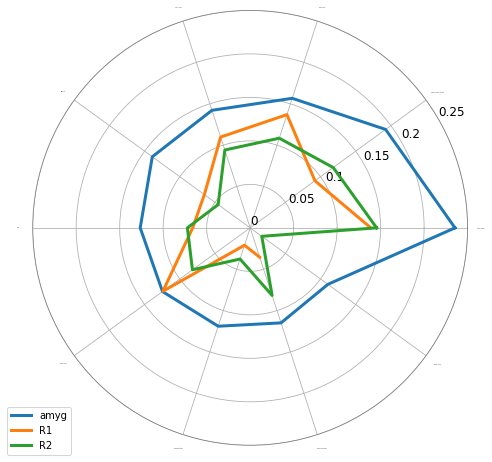

In [44]:
#make a spider plot of the top 10 most correlated words of the whole amygdala
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from math import pi

labe=['amyg','R1','R2']
# obtain df information
categories = list(df.head(10).index)
values=df.head(10).values.tolist()
values += values[:1] # repeat the first value to close the circular graph
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# define plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                        subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], categories, color='black', size=1)
plt.yticks(np.arange(0, 0.3, 0.05), [ '0','0.05', '0.1','0.15','0.2','0.25'], size=12,color='black')
plt.ylim(0, 0.25)
ax.set_rlabel_position(30)

# draw radar-chart:
for i in range(3):
    val_c1 = [row[i] for row in values]
    #val_c1 += val_c1[:1]
    plt.setp(ax.spines.values(), color='grey')
    ax.plot(angles, val_c1, linewidth=3, linestyle='solid',label=labe[i])
    #ax.fill(angles, val_c1, alpha=0.4)

# add legent and show plot
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
#plt.show()

In [45]:
#not sure what is the point of this
df=result
list(df.head(10).index)
categories = list(df.head(10).index)
values = df.mean().values.flatten().tolist()
values += values[:1] # repeat the first value to close the circular graph
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1] 
print(angles)
print(values)
values=df.head(10).values.tolist()
values += values[:1]

[0.0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759, 2.5132741228718345, 3.141592653589793, 3.7699111843077517, 4.39822971502571, 5.026548245743669, 5.654866776461628, 0.0]
[-0.2643556853809943, -0.3052981624234724, -0.2738058645573982, -0.2643556853809943]


In [55]:
#print table
df=df[:11].rename(columns={'Pearson\'s r':'Amyg'})
df[:11].style.background_gradient(axis=None)

,Amyg,bot25,top25
autobiographical,0.235511,0.138715,0.145441
autobiographical memory,0.192492,0.092079,0.117997
happy faces,0.156596,0.136871,0.108385
neutral faces,0.142091,0.109763,0.094126
memories,0.139070,0.065067,0.045470
happy,0.126406,0.066050,0.072161
fearful faces,0.124575,0.123985,0.082013
personality traits,0.118924,0.021001,0.037668
emotional valence,0.114873,0.035525,0.081705
mental states,0.110498,-0.043177,0.016534


In [62]:
#print table with better formatting of top 10 most correlated words
df[:10].style.background_gradient(cmap='bwr',vmin=-0.2, vmax=0.2,axis=None).format('')

,Amyg,bot25,top25
autobiographical,,,
autobiographical memory,,,
happy faces,,,
neutral faces,,,
memories,,,
happy,,,
fearful faces,,,
personality traits,,,
emotional valence,,,
mental states,,,
